In [1]:
from scipy import *
from numpy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
from scipy.io import loadmat
import scipy.sparse as sp
from scipy.sparse.linalg import eigs,spsolve,gmres,minres,cg
from scipy.sparse.linalg import LinearOperator,spilu
import networkx as nx
from skimage import data as testimages
from skimage.color import rgb2gray
from timeit import default_timer as timer
import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 8.1.1

Here we load the adjacency matrix of a graph with 2790 nodes. Each node is a web page referring to Roswell, NM, and the edges represent links between web pages.

In [3]:
vars = loadmat("roswelladj.mat")       # get from the book's website

A = sp.csr_matrix(vars["A"])
A.data.nbytes

67896

We may define the density of $\mathbf{A}$ as the number of nonzeros divided by the total number of entries.

In [4]:
m,n = A.shape
print("density:",A.nnz / (m*n))

density: 0.0010902994565845762


We can compare the storage space needed for the sparse $\mathbf{A}$ with the space needed for its dense or full counterpart. 

In [5]:
F = A.todense()
F.nbytes

62272800

Matrix-vector products are also much faster using the sparse form, because operations with structural zeros are skipped.

In [6]:
x = randn(n)
start = timer()
for i in range(200): A@x; 
print("sparse time:",timer() - start)

sparse time: 0.005995326995616779


In [7]:
start = timer()
for i in range(200): F@x; 
print("dense time:",timer() - start)

dense time: 0.44125359802274033


# Example 8.1.2

Here is the adjacency matrix of a graph representing a "small world" network featuring connections to neighbors and a small number of strangers. 

In [8]:
wsg = nx.watts_strogatz_graph(200,4,0.02);

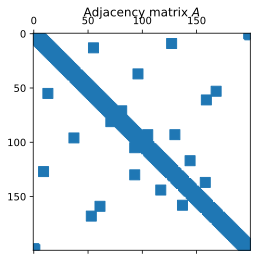

In [9]:
A = nx.adjacency_matrix(wsg);
spy(A);
title("Adjacency matrix $A$");

The number of vertex pairs connected by a path of length $k>1$ grows with $k$, as can be seen here for $k=6$. This would be "six degrees of separation." (For sparse matrices, the `**` notation does matrix power properly.)

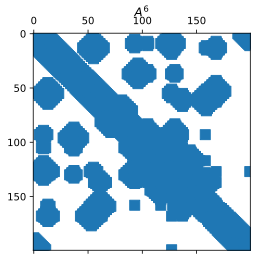

In [10]:
spy(A**6)
title("$A^6$");

# Example 8.1.3

Here is a matrix with both lower and upper bandwidth equal to one. Such a matrix is called *tridiagonal*. The `diags` function creates a sparse matrix given its diagonal elements. The main or central diagonal is numbered zero, above and to the right of that is positive, and below and to the left is negative.

In [11]:
n = 50;
data = [n*ones(n-3),ones(n),linspace(-1,1-n,n-1)]
A = sp.diags(data,[-3,0,1],format="lil")
print( A[:7,:7].todense() )

[[ 1. -1.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  0.  0.  0.  0.]
 [ 0.  0.  1. -3.  0.  0.  0.]
 [50.  0.  0.  1. -4.  0.  0.]
 [ 0. 50.  0.  0.  1. -5.  0.]
 [ 0.  0. 50.  0.  0.  1. -6.]
 [ 0.  0.  0. 50.  0.  0.  1.]]


Without pivoting, the LU factors have the same lower and upper bandwidth as the orignal matrix. 

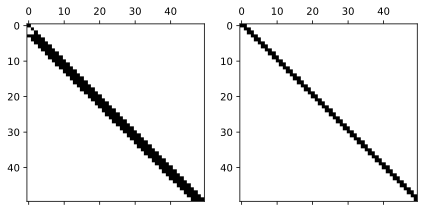

In [12]:
L,U = FNC.lufact(A.todense())
subplot(1,2,1)
spy(L)
subplot(1,2,2)
spy(U)

However, if we introduce row pivoting, bandedness may be expanded or destroyed.

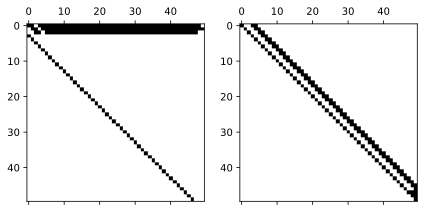

In [13]:
PL,U = lu(A.todense(),permute_l=True)
subplot(1,2,1)
spy(PL)
subplot(1,2,2)
spy(U)

# Example 8.1.4

The following generates a random sparse matrix with prescribed eigenvalues.

In [14]:
n = 4000
density = 1.23e-3
ev = 1/arange(1,n+1)
A = FNC.sprandsym(n,density,eigvals=ev)

In [15]:
A.nnz/prod(A.shape)

0.0012305

In [16]:
ev,V = eigs(A,k=5,which="LM")    # largest magnitude
ev

array([1.        +0.j, 0.5       +0.j, 0.33333333+0.j, 0.25      +0.j,
       0.2       +0.j])

In [17]:
ev,V = eigs(A,k=5,sigma=0)    # closest to zero
1 / ev

array([29000.85294584+0.j,  4000.        +0.j,  3999.        +0.j,
        3998.        +0.j,  3997.        +0.j])

The scaling of time to solve a sparse linear system is not easy to predict unless you have some more information about the matrix (such as bandedness). But it will typically be a great deal faster than the dense or full matrix case.

In [18]:
x = 1/arange(1,n+1);  b = A@x;
start = timer()
sparse_err = norm(x - spsolve(A,b))
print("sparse time:",timer()-start)

sparse time: 0.00550624099560082


In [19]:
norm(x-spsolve(A,b),2)

9.377863962015079e-15

In [20]:
A = A.todense()
start = timer()
dense_err = norm(x - solve(A,b))
print("dense time:",timer()-start)

dense time: 0.6881144259823486


In [21]:
[sparse_err, dense_err]

[9.377863962015079e-15, 1.2146082316113206e-14]

# Example 8.2.1

Here we let $\mathbf{A}$ be a $5\times 5$ matrix. We also choose a random 5-vector.

In [22]:
A = ceil(9*rand(5,5))
A = A/sum(A,0)
x = randn(5)

Applying matrix-vector multiplication once doesn't do anything recognizable.

In [23]:
y = A@x
y

array([0.71024052, 0.47621259, 0.26168636, 0.74237527, 0.5623407 ])

Repeating the multiplication still doesn't do anything obvious.

In [24]:
z = A@y
z

array([0.67692367, 0.48784236, 0.36054702, 0.64934899, 0.5781934 ])

But if we keep repeating the matrix-vector multiplication, something remarkable happens: $\mathbf{A}\mathbf{x}\approx \mathbf{x}$. 

In [25]:
for j in range(8):  x = A@x
[x, A@x]

[array([0.67848253, 0.48941796, 0.34872014, 0.66643404, 0.56980077]),
 array([0.67848265, 0.48941766, 0.34871799, 0.66643775, 0.5697994 ])]

This seems to occur regardless of the starting value of $x$. 

In [26]:
x = randn(5)
for j in range(8): x = A@x
[x, A@x]

[array([-0.03760082, -0.02712437, -0.01933321, -0.03692094, -0.03158278]),
 array([-0.03760133, -0.02712308, -0.01932407, -0.0369367 , -0.03157694])]

# Example 8.2.2

We set up a $5\times 5$ matrix with prescribed eigenvalues, then apply the power iteration.

In [27]:
ev = [1,-0.75,0.6,-0.4,0]
A = triu(ones([5,5]),1) + diag(ev)   # triangular matrix, eigs on diagonal

We run the power iteration 60 times. The best estimate of the dominant eigenvalue is the last entry of `gamma`. 

In [28]:
gamma,x = FNC.poweriter(A,60)
eigval = gamma[-1]
print(gamma)

[-1.48478152 -4.69058747  1.18658122  1.43650584  1.00367791  1.13568914
  0.98353037  1.05717694  0.98475943  1.02703618  0.98927027  1.01360141
  0.99317191  1.00711127  0.99586892  1.00381289  0.99757063  1.00207874
  0.99859523  1.00114582  0.99919601  1.00063614  0.99954279  1.00035482
  0.99974103  1.00019851  0.99985368  1.00011128  0.99991747  1.00006245
  0.99995349  1.00003508  0.99997381  1.00001971  0.99998526  1.00001108
  0.9999917   1.00000623  0.99999533  1.0000035   0.99999737  1.00000197
  0.99999852  1.00000111  0.99999917  1.00000062  0.99999953  1.00000035
  0.99999974  1.0000002   0.99999985  1.00000011  0.99999992  1.00000006
  0.99999995  1.00000004  0.99999997  1.00000002  0.99999999  1.00000001]


We check linear convergence using a log-linear plot of the error. We use our best estimate in order to compute the error at each step.

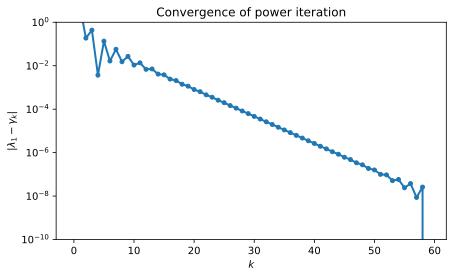

In [29]:
err = eigval - gamma
semilogy(arange(60),abs(err),"-o")
ylim(1e-10,1)
xlabel("$k$"); ylabel("$|\lambda_1 - \gamma_k|$");
title("Convergence of power iteration");

The trend is clearly a straight line asymptotically. We can get a refined estimate of the error reduction in each step by using the exact eigenvalues.

In [30]:
print("theory:",ev[1]/ev[0])
print("observed:",err[40]/err[39])

theory: -0.75
observed: -0.754992822746387


Note that the error is supposed to change sign on each iteration. An effect of these alternating signs is that estimates oscillate around the exact value.

# Example 8.3.1

We set up a $5\times 5$ triangular matrix with prescribed eigenvalues on its diagonal.

In [31]:
ev = [1,-0.75,0.6,-0.4,0]
A = triu(ones([5,5]),1) + diag(ev)   # triangular matrix, eigs on diagonal

We run inverse iteration with the shift $s=0.7$ and take the final estimate as our ``exact'' answer to observe the convergence. 

In [32]:
gamma,x = FNC.inviter(A,0.7,30)
eigval = gamma[-1]
print(eigval)

0.5999999999999986


As expected, the eigenvalue that was found is the one closest to $0.7$. The convergence is again linear.

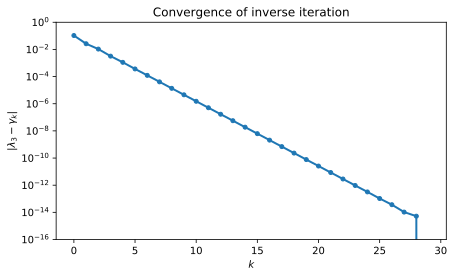

In [33]:
err = eigval - gamma
semilogy(arange(30),abs(err),"-o")
ylim(1e-16,1)
xlabel("$k$"); ylabel("$|\lambda_3 - \gamma_k|$")
title("Convergence of inverse iteration");

The observed linear convergence rate is found from the data. In the numbering of this example, the eigenvalue closest to $s=0.7$ is $\lambda_3$ and the next-closest is $\lambda_1$.

In [34]:
print("theory:",(ev[2]-0.7) / (ev[0]-0.7))
print("observed:",err[21]/err[20])

theory: -0.3333333333333332
observed: -0.33326140713536656


# Example 8.3.2

In [35]:
ev = [1,-0.75,0.6,-0.4,0]
A = triu(ones([5,5]),1) + diag(ev)   # triangular matrix, eigs on diagonal

We begin with a shift $s=0.7$, which is closest to the eigenvalue 0.6.

In [36]:
s = 0.7
x = ones(5)
y = solve(A-s*eye(5),x)
gamma = x[0]/y[0] + s
print(gamma)

0.7034813925570228


Note that the result is not yet any closer to the targeted $0.6$. But we proceed (without being too picky about normalization here).

In [37]:
s = gamma
x = y/y[0]
y = solve(A-s*eye(5),x)
gamma = x[0]/y[0] + s
print(gamma)

0.5612761406172997


Still not much apparent progress. However, in just a few more iterations the results are dramatically better.

In [38]:
for k in range(4):
    s = gamma
    x = y/y[0]
    y = solve(A-s*eye(5),x)
    gamma = x[0]/y[0] + s
    print(gamma)

0.5964312884753865
0.5999717091820104
0.5999999978556353
0.6


# Example 8.4.1

First we define a triangular matrix with known eigenvalues and a random vector $b$.

In [39]:
ev = 10 + arange(1,101)
A = triu(rand(100,100),1) + diag(ev)
b = rand(100)

Next we build up the first ten Krylov matrices iteratively, using renormalization after each matrix-vector multiplication. 

In [40]:
Km = zeros([100,30])
Km[:,0] = b
for m in range(29):     
    v = A@Km[:,m]
    Km[:,m+1] = v/norm(v)

Now we solve a least squares problem for Krylov matrices of increasing dimension.

In [41]:
resid = zeros(30)
resid[0] = norm(b)
for m in range(1,30):  
    z = lstsq(A@Km[:,:m],b,rcond=None)[0]
    x = Km[:,:m]@z
    resid[m] = norm(b-A@x)

The linear system approximations show smooth linear convergence at first, but the convergence stagnates after only a few digits have been found.

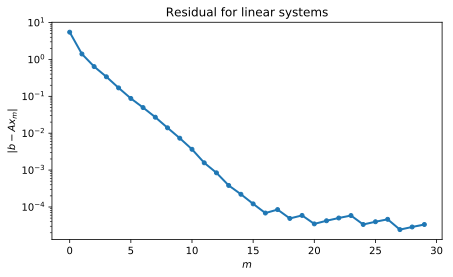

In [42]:
semilogy(range(30),resid,"-o")
xlabel("$m$"); ylabel("$\| b-Ax_m \|$"); 
title("Residual for linear systems");

# Example 8.4.2

We illustrate a few steps of the Arnoldi iteration for a small matrix.

In [43]:
A = ceil(9*rand(6,6))

The seed vector determines the first member of the orthonormal basis.

In [44]:
u = randn(6)
Q = zeros([6,3])
Q[:,0] = u/norm(u)

Multiplication by $\mathbf{A}$ gives us a new vector in $\mathcal{K}_2$. 

In [45]:
Aq = A@Q[:,0]

We subtract off its projection in the previous direction. The remainder is rescaled to give us the next orthonormal column.

In [46]:
v = Aq - dot(Q[:,0],Aq)*Q[:,0]
Q[:,1] = v/norm(v)

On the next pass, we have to subtract off the projections in two previous directions.

In [47]:
Aq = A@Q[:,1]
v = Aq - dot(Q[:,0],Aq)*Q[:,0] - dot(Q[:,1],Aq)*Q[:,1]
Q[:,2] = v/norm(v)

At every step, $Q_m$ is an ONC matrix.

In [48]:
norm( Q.T@Q - eye(3) )

1.0587426813435408e-15

And $Q_m$ spans the same space as the 3-dimensional Krylov matrix.

In [49]:
K = stack([u,A@u,A@A@u],axis=-1)
print( matrix_rank( hstack([Q,K]) ))

3


# Example 8.5.1

We define a triangular matrix with known eigenvalues and a random vector $b$.

In [50]:
ev = 10 + arange(1,101)
A = triu(rand(100,100),1) + diag(ev)
b = rand(100)

Instead of building up the Krylov matrices, we use the Arnoldi iteration to generate equivalent orthonormal vectors. 

In [51]:
Q,H = FNC.arnoldi(A,b,60)
print(H[:5,:5])

[[78.59373534 35.7741113   9.40729741  0.11713078  3.32745172]
 [24.25134254 51.76164205 26.64012228  0.94125674  0.89595404]
 [ 0.         21.755196   56.654071   24.97592987  0.2398351 ]
 [ 0.          0.         23.14795965 55.64529249 25.61824102]
 [ 0.          0.          0.         25.0208378  60.8320755 ]]


The Arnoldi bases are used to solve the least squares problems defining the GMRES iterates. 

In [52]:
resid = zeros(61)
resid[0] = norm(b)
for m in range(1,61):  
    s = hstack([norm(b),zeros(m)])
    z = lstsq(H[:m+1,:m],s,rcond=None)[0]
    x = Q[:,:m]@z
    resid[m] = norm(b-A@x)

The approximations converge smoothly, practically all the way to machine epsilon.

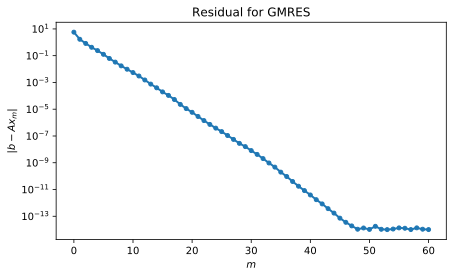

In [53]:
semilogy(range(61),resid,"-o")
xlabel("$m$"); ylabel("$\| b-Ax_m \|$"); 
title("Residual for GMRES");

# Example 8.5.2

The following experiments are based on a matrix resulting from discretization of a partial differential equation.

In [54]:
def poisson2d(m):
    n = m**2
    d0 = [4.]*n
    d1 = [-1.]*(n-1)
    d1[m-1::m] = zeros(m-1)
    dm = array([-1.]*(n-m))
    return sp.diags([d0,d1,d1,dm,dm],[0,1,-1,m,-m],format="csc")

In [55]:
d = 50;
A = d**2*poisson2d(d)
n = d**2
b = ones(n)

In [56]:
ctr = lambda rvec: resid.append(norm(rvec))
resid = [norm(b)]
x,flag = gmres(A,b,restart=None,tol=1e-8,atol=1e-14,maxiter=120,callback=ctr)

We compare unrestarted GMRES with three different thresholds for restarting.

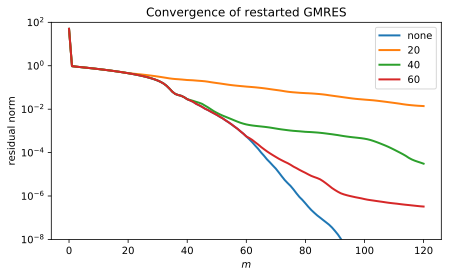

In [57]:
maxit = 120;  rtol = 1e-8;
restarts = [maxit,20,40,60]
hist = lambda rvec: resid.append(norm(rvec))
for r in restarts:
    resid = [norm(b)]
    x,flag = gmres(A,b,restart=r,tol=rtol,atol=1e-14,maxiter=maxit,callback=hist)   
    semilogy(resid)
xlabel("$m$"); ylabel("residual norm");
ylim(1e-8,100);
legend(["none","20","40","60"]);
title("Convergence of restarted GMRES");

The "pure" curve is the lowest one. All of the other curves agree with it until they encounter their first restart. 

# Example 8.6.1

In this example we compare MINRES and CG on some pseudorandom SPD problems.  The first matrix has a condition number of 100. 

In [58]:
n = 2000
density = 0.005
A = FNC.sprandsym(n,density,rcond=1e-2)
A.nnz

20012

We cook up a linear system whose solution we happen to know exactly.

In [59]:
x = arange(1,n+1)/n
b = A@x

Now we apply both methods and compare the convergence of the system residuals, using the built-in function `pcg` in the latter case.

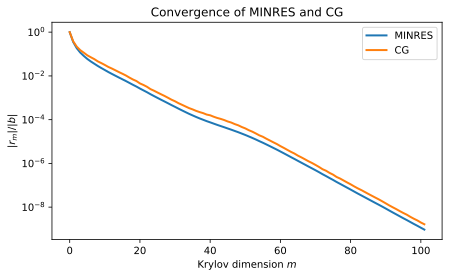

In [60]:
hist = lambda x: resid.append(norm(b-A@x))

resid = [norm(b)]
xMR,flag = minres(A,b,tol=1e-12,maxiter=101,callback=hist)
semilogy(resid/norm(b),label="MINRES")

resid = [norm(b)]
xCG,flag = cg(A,b,tol=1e-12,atol=1e-14,maxiter=101,callback=hist)
semilogy(resid/norm(b),label="CG")

xlabel("Krylov dimension $m$");  ylabel("$|r_m\| / \|b\|$");
legend(); title("Convergence of MINRES and CG");

There is virtually no difference between the two methods here when measuring the residual. We see little difference in the errors as well. 

In [61]:
print("MINRES error:",norm(xMR - x) / norm(x))
print("CG error:",norm(xCG - x) / norm(x))

MINRES error: 1.5071173005145568e-08
CG error: 9.427046540412616e-09


Next we use a system matrix whose condition number is $10^4$. 

In [62]:
A = FNC.sprandsym(n,density,rcond=1e-4)

Now we find that the CG residual jumps unexpectedly, but overall both methods converge at about the same linear rate. Note from the scales that both methods have actually made very little progress after 100 iterations, though. 

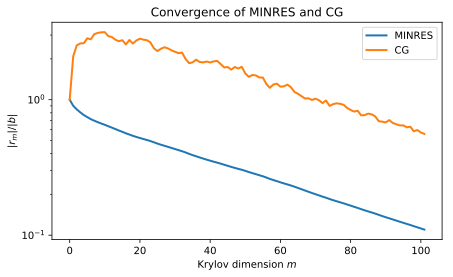

In [63]:
resid = [norm(b)]
xMR,flag = minres(A,b,tol=1e-12,maxiter=101,callback=hist)
semilogy(resid/norm(b),label="MINRES")

resid = [norm(b)]
xCG,flag = cg(A,b,tol=1e-12,atol=1e-14,maxiter=101,callback=hist)
semilogy(resid/norm(b),label="CG")

xlabel("Krylov dimension $m$");  ylabel("$\\|r_m\\| / \\|b\\|$");
legend(); title("Convergence of MINRES and CG");

The errors confirm that we are nowhere near the correct solution in either case.

In [64]:
print("MINRES error:",norm(xMR - x) / norm(x))
print("CG error:",norm(xCG - x) / norm(x))

MINRES error: 579.2203917823894
CG error: 665.2206678478602


# Example 8.7.1

We use a readily available test image.

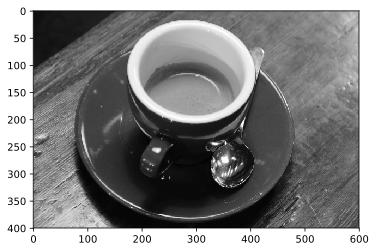

In [65]:
img = getattr(testimages,"coffee")()
X = rgb2gray(img)
m,n = X.shape
imshow(X,cmap="gray");

We define the one-dimensional tridiagonal blurring matrices.

In [66]:
B = sp.diags([[0.5]*m,[0.25]*(m-1),[0.25]*(m-1)],[0,1,-1])  
C = sp.diags([[0.5]*n,[0.25]*(n-1),[0.25]*(n-1)],[0,1,-1])  

Finally, we show the results of using $k=12$ repetitions of the blur in each direction.

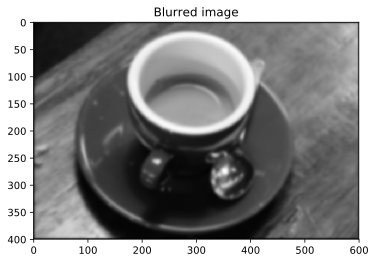

In [67]:
blur = lambda X: B**12 @ X @ C**12
imshow(blur(X),cmap="gray")
title("Blurred image");

# Example 8.7.2

We repeat the earlier process to blur the original image $X$ to get $Z$. 

In [68]:
img = getattr(testimages,"coffee")()
X = rgb2gray(img)
m,n = X.shape

B = sp.diags([[0.5]*m,[0.25]*(m-1),[0.25]*(m-1)],[0,1,-1])  
C = sp.diags([[0.5]*n,[0.25]*(n-1),[0.25]*(n-1)],[0,1,-1])  
blur = lambda X: B**12 @ X @ C**12
Z = blur(X)

Now we imagine that $X$ is unknown and that the blurred $Z$ is given. We want to invert the blur transformation using the transformation itself. But we have to translate between vectors and images each time. 

In [69]:
vec = lambda Z: Z.reshape(m*n)
unvec = lambda z: z.reshape(m,n)
xform = lambda x: vec(blur(unvec(x)))
T = LinearOperator((m*n,m*n),matvec=xform)

Now we apply `gmres` to the composite blurring transformation `T`.

In [70]:
y,flag = gmres(T,vec(Z),tol=rtol,atol=1e-14,maxiter=50)   
Y = unvec(maximum(0,minimum(1,y)))

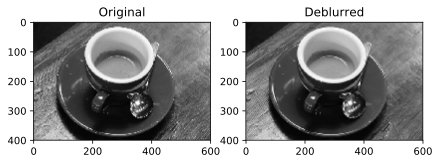

In [71]:
subplot(1,2,1)
imshow(X,cmap="gray")
title("Original")
subplot(1,2,2)
imshow(Y,cmap="gray")
title("Deblurred");

The reconstruction isn't perfect because the condition number of repeated blurring happens to be very large. 

# Example 8.8.1

Here is a large sparse matrix.

In [72]:
A = 2.8*sp.eye(10000) + sp.rand(10000,10000,0.002);

Without a preconditioner, GMRES takes a large number of iterations. 

In [73]:
b = rand(10000)
hist = lambda rvec: resid.append(norm(rvec))
resid = [norm(b)]

start = timer()
x,flag = gmres(A,b,maxiter=300,tol=1e-10,restart=50,callback=hist);
print("time for plain GMRES:",timer()-start) 
resid1 = resid;

time for plain GMRES: 0.14819759700912982


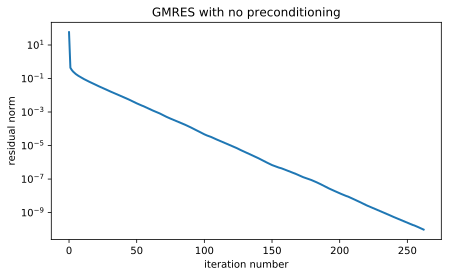

In [74]:
semilogy(resid)
xlabel("iteration number"); ylabel("residual norm");
title("GMRES with no preconditioning");

This version of incomplete $LU$ factorization drops all sufficiently small values (i.e., replaces them with zeros). This keeps the number of nonzeros in the factors under control.

In [75]:
iLU = spilu(A,drop_tol=0.2);

/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


It does _not_ produce a true factorization of $A$. However, it's close enough to serve as "approximate inverse" in a preconditioner. 

The actual preconditioning matrix is $\mathbf{M}=\mathbf{L}\mathbf{U}$. However, we just supply the factorization as a left preconditioner, since the preconditioning step is to solve a system with the matrix $\mathbf{M}$.

In [76]:
prec = LinearOperator((10000,10000),matvec=lambda y: iLU.solve(y))
resid = [norm(b)]

start = timer()
x,flag = gmres(A,b,M=prec,maxiter=300,tol=1e-10,restart=50,callback=hist);
print("time for preconditioned GMRES:",timer()-start) 
resid2 = resid

time for preconditioned GMRES: 0.16784676298266277


The preconditioning is fairly successful in this case.

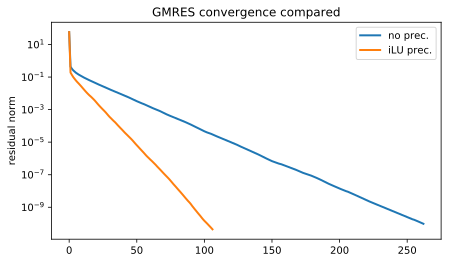

In [77]:
semilogy(resid1,label="no prec.")
semilogy(resid2,label="iLU prec.")
ylabel("iteration number"); ylabel("residual norm");
legend(); title("GMRES convergence compared");

We probably made each GMRES iteration slower because of the need to apply the preconditioner (here, by solving sparse triangular systems). However, there are a lot fewer iterations needed, and there is a modest gain overall.

# Example 8.8.2

At this writing, I am unaware of any major Python library for the incomplete Cholesky factorization, so this example is omitted. 